In [143]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn import metrics
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict

In [2]:
# lets explore movies.csv
data= pd.read_csv('ml-latest-small/movies.csv')
data.shape

(9742, 3)

In [3]:
data.head() #displays first 5 entries 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [6]:
#number of unique movies
movies = data['movieId'].unique().tolist()
len(movies)

9742

In [7]:
# lets explore ratings.CSV
ratings_data=pd.read_csv('ml-latest-small/ratings.csv',sep=',')
ratings_data.shape

(100836, 4)

In [8]:
#summary of ratings.csv
ratings_data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [9]:
#minimum rating given to a movie
print(ratings_data['rating'].min())
#maximum rating given to a movie
print(ratings_data['rating'].max())

#How many unique rating values exist
print(len(ratings_data['rating'].unique()))

0.5
5.0
10


In [10]:
print(ratings_data)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
5            1       70     3.0   964982400
6            1      101     5.0   964980868
7            1      110     4.0   964982176
8            1      151     5.0   964984041
9            1      157     5.0   964984100
10           1      163     5.0   964983650
11           1      216     5.0   964981208
12           1      223     3.0   964980985
13           1      231     5.0   964981179
14           1      235     4.0   964980908
15           1      260     5.0   964981680
16           1      296     3.0   964982967
17           1      316     3.0   964982310
18           1      333     5.0   964981179
19           1      349     4.0   964982563
20           1      356     4.0   964980962
21           1      362     5.0 

In [11]:
ratings_data.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

# Question 1:
Compute the sparsity of the movie rating dataset, where spar- sity is defined by equation 1

In [12]:
user_count = len(ratings_data['userId'].unique())
movie_count = len(ratings_data['movieId'].unique())
ratings_count = len(ratings_data)

In [13]:
sparsity = ratings_count/(user_count*movie_count)

In [14]:
print(sparsity)

0.016999683055613623


# Question 2: 
Plot a histogram showing the frequency of the rating values.
To be specific, bin the rating values into intervals of width 0.5 
and use the binned rating values as the horizontal axis. 
Count the number of entries in the ratings matrix R with
rating values in the binned intervals and use this count as the vertical axis.
Briefly comment on the shape of the histogram

In [15]:
ratings_list = np.linspace(0.5,5.0,10)
ratings_list_count = []

for rating in ratings_list:
    temp_rating = ratings_data['rating'] == rating
    temp_rating = ratings_data[temp_rating]
    ratings_list_count.append(len(temp_rating))


In [16]:
ratings_list = np.linspace(0.5,5.0,10)
print(ratings_list)
print(ratings_list_count)
print(np.sum(ratings_list_count))

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[1370, 2811, 1791, 7551, 5550, 20047, 13136, 26818, 8551, 13211]
100836


Text(0.5, 1.0, 'Distribution Across Ratings')

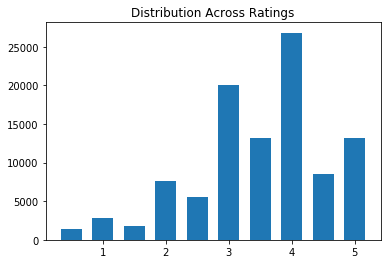

In [17]:
plt.bar(ratings_list,ratings_list_count,width = 1/3)
plt.title("Distribution Across Ratings")

# Question 3:
Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by de- creasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.

In [18]:
print(ratings_data.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [19]:
most_rated = ratings_data.groupby('movieId').size().sort_values(ascending=False)
movie_rating_count = []
for movie in most_rated.keys():
    movie_rating_count.append(most_rated[movie])

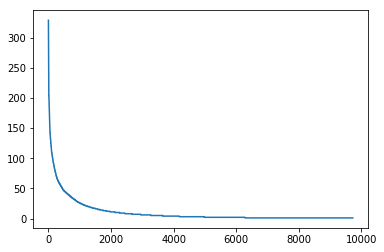

In [20]:
plt.plot(range(len(most_rated)), movie_rating_count)

# Question 4:
Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3.

In [21]:
most_rated_users = ratings_data.groupby('userId').size().sort_values(ascending=False)
most_rated_users_count = []
for user in most_rated_users.keys():
    most_rated_users_count.append(most_rated_users[user])

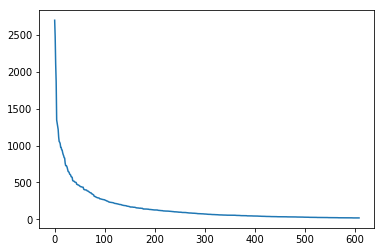

In [22]:
plt.plot(range(len(most_rated_users)), most_rated_users_count)

# Question 5:
Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.


# Question 6: 
Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram

In [23]:
movie_rating_list = {}
for movie in ratings_data['movieId']:
    temp_movie = ratings_data['movieId'] == movie
    temp_movie = ratings_data[temp_movie]
    movie_rating_list[movie] = temp_movie['rating'].values.tolist()

In [24]:
var_list = []
for movie in movie_rating_list.keys():
    var_list.append(np.var(movie_rating_list[movie]))   

In [25]:
print(len(var_list))

9724


In [26]:
list_of_variance_in_bins = np.digitize(var_list, ratings_list, right=True)
unique, counts = np.unique(list_of_variance_in_bins, return_counts=True)
print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8 10]
[6087 2356  880  248   94   21   29    6    1    2]


Text(0.5, 1.0, 'Variance Distribution Across Movie Ratings')

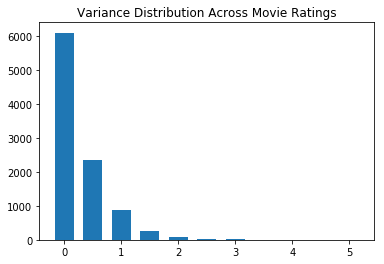

In [27]:
plt.bar(unique/2,counts,width = 1/3)
plt.title("Variance Distribution Across Movie Ratings")

# Question 7: 
Write down the formula for μu in terms of Iu and ruk

# Question 8:
In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅
(Hint: Rating matrix R is sparse).

# Question 9:
Can you explain the reason behind mean-centering the raw rat- ings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function)

# Question 10:
Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE (Mean Absolute Error) obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

In [28]:
ratings_data = ratings_data.drop(columns = ['timestamp'])
reader = Reader(rating_scale=(0.5, 5), sep=',', skip_lines = 1)
data = Dataset.load_from_df(ratings_data, reader)
sim_options = {'name': 'pearson'}

In [29]:
avg_rmse = []
avg_mae = []

for k in np.arange(2,102,2):
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=True)
    cv_results = cross_validate(algo, data, measures=[u'rmse', u'mae'], cv=10, return_train_measures=False, n_jobs= -1, verbose=True)
    avg_rmse.append(np.average(cv_results['test_rmse']))
    avg_mae.append(np.average(cv_results['test_mae']))
    

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0070  1.0340  1.0231  1.0220  1.0150  1.0175  1.0265  1.0245  1.0146  1.0049  1.0189  0.0085  
MAE (testset)     0.7811  0.7946  0.7901  0.7856  0.7882  0.7860  0.7868  0.7879  0.7867  0.7751  0.7862  0.0049  
Fit time          0.38    0.38    0.38    0.39    0.37    0.41    0.54    0.42    0.40    0.40    0.41    0.05    
Test time         0.38    0.39    0.37    0.37    0.36    0.45    0.52    0.41    0.41    0.37    0.40    0.05    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9407  0.9386  0.9617  0.9570  0.9455  0.9478  0.9430  0.9382  0.9458  0.9464  0.9465  0.0072  
MAE (testset)     0.7195  0.7218  0.7343  0.7383  0.7262  0.7260  0

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8892  0.8930  0.9001  0.8843  0.8895  0.8923  0.8917  0.8786  0.8865  0.8913  0.8896  0.0054  
MAE (testset)     0.6773  0.6795  0.6801  0.6726  0.6754  0.6819  0.6767  0.6725  0.6805  0.6799  0.6776  0.0031  
Fit time          0.39    0.38    0.59    0.54    0.61    0.52    0.47    0.58    0.43    0.39    0.49    0.08    
Test time         0.74    0.68    1.26    1.24    0.83    0.91    0.93    0.83    0.84    0.70    0.90    0.19    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8995  0.8992  0.8945  0.8917  0.8818  0.8907  0.8811  0.8848  0.8890  0.8929  0.8905  0.0062  
MAE (testset)     0.6826  0.6839  0.6801  0.6768  0.6743  0.6805  0

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8903  0.9024  0.8811  0.8919  0.8856  0.8936  0.8934  0.9027  0.8795  0.8807  0.8901  0.0080  
MAE (testset)     0.6778  0.6871  0.6682  0.6803  0.6743  0.6809  0.6828  0.6858  0.6709  0.6720  0.6780  0.0061  
Fit time          0.37    0.38    0.40    0.41    0.41    0.39    0.41    0.40    0.41    0.39    0.40    0.01    
Test time         0.78    0.79    0.83    0.86    0.86    0.84    0.84    0.82    0.84    0.75    0.82    0.03    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8860  0.8834  0.8965  0.8873  0.8978  0.8857  0.8960  0.8860  0.8836  0.8943  0.8897  0.0055  
MAE (testset)     0.6801  0.6707  0.6794  0.6711  0.6844  0.6757  0

Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8801  0.8950  0.9010  0.8816  0.8966  0.8737  0.8948  0.8964  0.8923  0.8951  0.8907  0.0085  
MAE (testset)     0.6728  0.6755  0.6849  0.6726  0.6848  0.6686  0.6804  0.6810  0.6786  0.6802  0.6779  0.0051  
Fit time          0.38    0.38    0.41    0.41    0.40    0.41    0.41    0.40    0.42    0.39    0.40    0.01    
Test time         0.82    0.85    0.90    0.89    0.87    0.88    0.90    0.87    0.91    0.80    0.87    0.04    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8913  0.8941  0.8778  0.8895  0.8902  0.9018  0.8884  0.8933  0.8935  0.8940  0.8914  0.0057  
MAE (testset)     0.6812  0.6800  0.6680  0.6783  0.6746  0.6856  0

In [30]:
print(cv_results['test_rmse'])
np.average(cv_results['test_rmse'])

[0.88363136 0.89551669 0.89853472 0.89856649 0.90156755 0.8906516
 0.87437126 0.88881748 0.88382741 0.88827143]


0.8903755995567673

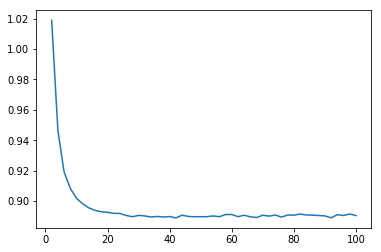

In [31]:
plt.plot(np.arange(2,102,2), avg_rmse)

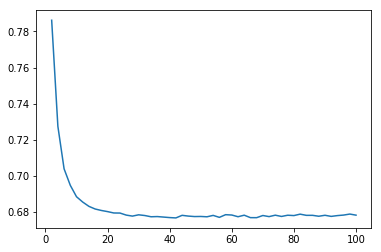

In [32]:
plt.plot(np.arange(2,102,2), avg_mae)

# Question 11:
Use the plot from question 10, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE

In [33]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(avg_mae)
pp.pprint(avg_rmse)

[   0.7862011225896371,
    0.72738399879434,
    0.7038346795276758,
    0.6946937224823934,
    0.68837443962586,
    0.6854178261348938,
    0.6830356654060538,
    0.6815721101081409,
    0.6807610273116733,
    0.6801286115955264,
    0.6793693210050737,
    0.679326467584599,
    0.6781997954891081,
    0.6776338140911458,
    0.6783528512159359,
    0.6779538918459802,
    0.6772716164729584,
    0.6773801001338712,
    0.6771012530656554,
    0.6768169251366757,
    0.6766319345084011,
    0.6780645640039289,
    0.6776472397032631,
    0.6773849581174193,
    0.6774406357528039,
    0.6772562249124072,
    0.6780281905554592,
    0.6769442378432754,
    0.6784225561392357,
    0.6782346440068114,
    0.6772897295759928,
    0.678141593028234,
    0.6767826959388029,
    0.6767684861415112,
    0.677966137494386,
    0.6773549078724372,
    0.6781482544495441,
    0.6774465723891809,
    0.6781183140805976,
    0.6779299815878381,
    0.6787194169381695,
    0.6780587160527715,

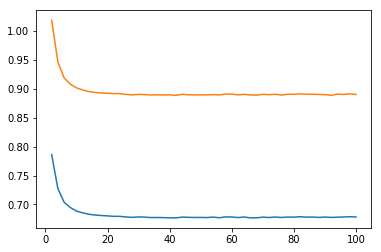

In [34]:
plt.plot(np.arange(2,102,2), avg_mae)
plt.plot(np.arange(2,102,2), avg_rmse)

# Question 12
Design a k-NN collaborative lter to predict the ratings of the
movies in the popular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in
step sizes of 2, and for each k compute the average RMSE obtained by averaging
the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
Also, report the minimum average RMSE


In [37]:
def trim_data(testset, mode):
    vardict_temp = {}
    for index, value in enumerate(testset):
        try:
            testdict[value[1]] += 1
        except:
            testdict[value[1]] = 1
    for index, value in enumerate(testset):
        try:
            vardict_temp[value[1]].append(value[2])
        except:
            vardict_temp[value[1]] = [value[2]]

    for i in list(vardict_temp.keys()):
        vardict[i] = np.var(vardict_temp[i])

    for i in list(testdict.keys()):
        if(mode == 'less'):
            if(testdict[i]<=2):
                del(testdict[i])
        elif(mode == 'more'):
            if(testdict[i]>2):
                del(testdict[i])
        elif(mode == 'variance'):
            if(testdict[i]<5):
                del(testdict[i])
            elif(vardict[i]<2):
                del(testdict[i])
            
    keys_to_keep = list(testdict.keys())
    return keys_to_keep
    

In [38]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines = 1)

data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [39]:
kf = KFold(n_splits=10)
sim_options = {'name': 'pearson'}
rmse_list = list()

for k in np.arange(2,102,2):
#     print(k)
    rmse = 0
    mae = 0
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        keys_to_delete = trim_data(testset, 'less')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        predictions = algo.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)

0.8538784089225627


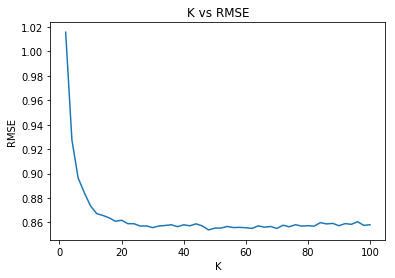

In [40]:
plt.plot(np.arange(2,102,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 13
Design a k-NN collaborative lter to predict the ratings of the
movies in the unpopular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in
step sizes of 2, and for each k compute the average RMSE obtained by averaging
the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis).
Also, report the minimum average RMSE

In [41]:
kf = KFold(n_splits=10)
sim_options = {'name': 'pearson'}
rmse_list = list()
for k in np.arange(2,102,2):
    print(k)
    rmse = 0
    mae = 0
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        keys_to_delete = trim_data(testset, 'more')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        predictions = algo.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)


2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100


0.9498746234224015


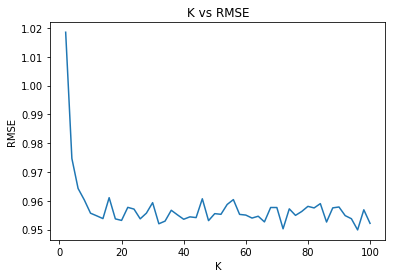

In [42]:
plt.plot(np.arange(2,102,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 14
Design a k-NN collaborative lter to predict the ratings of the
movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to
100 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [44]:
kf = KFold(n_splits=10)
sim_options = {'name': 'pearson'}
rmse_list = list()
mae_list = list()
for k in np.arange(2,102,2):
    print(k)
    rmse = 0
    mae = 0
    algo = KNNWithMeans(k=k, sim_options=sim_options, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        keys_to_keep = trim_data(testset, 'variance')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_keep]
        predictions = algo.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100


1.3533434539133324


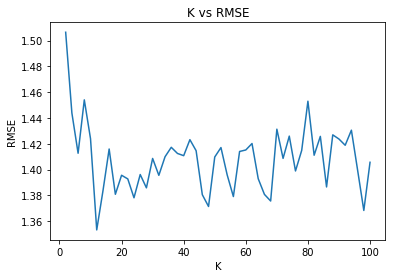

In [45]:
plt.plot(np.arange(2,102,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 15
Plot the ROC curves for the k-NN collaborative lter designed
in question 10 for threshold values [2:5; 3; 3:5; 4]. For the ROC plotting use the
k found in question 11. For each of the plots, also report the area under the
curve (AUC) value.

In [92]:
def convert_predictions_for_ROC(predictions, threshold):
    true_list = list()
    for i in predictions:
        if(i.r_ui>=threshold):
            true_list.append(1)
        else:
            true_list.append(0)
    return true_list

In [93]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines = 1)

data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)
sim_options = {'name': 'pearson'}
algo_knn = KNNWithMeans(k=28, sim_options=sim_options, verbose=True)
trainset, testset = train_test_split(data, test_size=.1)
algo_knn.fit(trainset)
predictions_knn = algo_knn.test(testset)
predicted_knn = [i.est for i in predictions_knn]
true_25 = convert_predictions_for_ROC(predictions_knn, 2.5)
true_3 = convert_predictions_for_ROC(predictions_knn, 3)
true_35 = convert_predictions_for_ROC(predictions_knn, 3.5)
true_4 = convert_predictions_for_ROC(predictions_knn, 4)

Computing the pearson similarity matrix...
Done computing similarity matrix.


0.7751312833068136


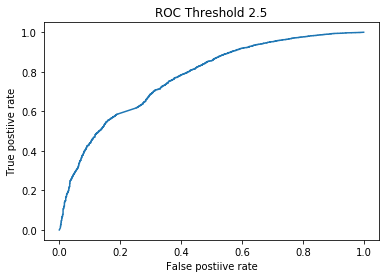

In [94]:
fpr, tpr, _ = metrics.roc_curve(true_25, predicted_knn)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 2.5')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

0.7770546300480138


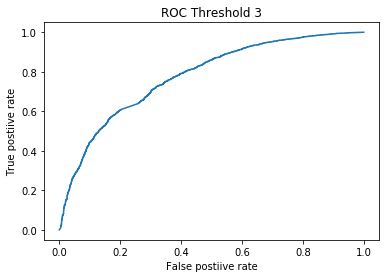

In [95]:
fpr, tpr, _ = metrics.roc_curve(true_3, predicted_knn)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 3')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

0.7730944882400153


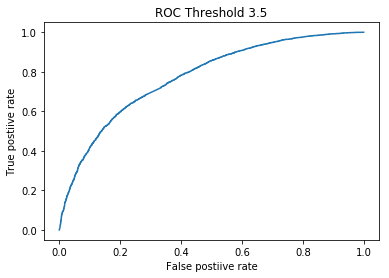

In [96]:
fpr, tpr, _ = metrics.roc_curve(true_35, predicted_knn)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 3.5')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

0.7630703190706449


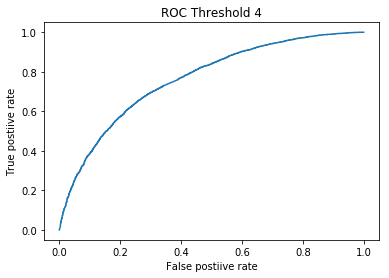

In [97]:
fpr, tpr, _ = metrics.roc_curve(true_4, predicted_knn)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 4')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

# Question 16
Is the optimization problem given by equation 5 convex? Consider
the optimization problem given by equation 5. For U xed, formulate it as a
least-squares problem.

# Question 17
Design a NNMF-based collaborative lter to predict the ratings of
the movies in the MovieLens dataset and evaluate it's performance using 10-fold
cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes

In [98]:
avg_rmse = []
avg_mae = []

for k in np.arange(2,52,2):
    algo = NMF(n_factors = k, verbose=True)
    cv_results = cross_validate(algo, data, measures=[u'rmse', u'mae'], cv=10, return_train_measures=False, n_jobs= -1, verbose=True)
    avg_rmse.append(np.average(cv_results['test_rmse']))
    avg_mae.append(np.average(cv_results['test_mae']))
plt.plot(np.arange(2,102,2), avg_mae)
plt.title('Average MAE')
plt.xlabel('k')
plt.ylabel('Avg_MAE')
plt.figure()
plt.plot(np.arange(2,102,2), avg_rmse)    
plt.title('Average RMSE')
plt.xlabel('k')
plt.ylabel('Avg_RMSE')

KeyboardInterrupt: 

exception calling callback for <Future at 0x11e0bee10 state=finished returned list>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 510, in apply_async
    future = self._workers.submit(SafeFunction(func))
AttributeError: 'NoneType' object has no 

# Question 18
Use the plot from question 17, to nd the optimal number of
latent factors. Optimal number of latent factors is the value of k that gives
the minimum average RMSE or the minimum average MAE. Please report the
minimum average RMSE and MAE. Is the optimal number of latent factors
same as the number of movie genres?

ANSWER: NO!

In [53]:
print(avg_rmse)

[1.1426192493993688, 1.0378905101510214, 0.9841064542724025, 0.9472353795720043, 0.9292553092380793, 0.9202363493397436, 0.9146591110533027, 0.9115831554526123, 0.9107593485611132, 0.9128231906541483, 0.9156636051346766, 0.9185473871070963, 0.9217844006160473, 0.9258947238435378, 0.9291470188170073, 0.9325834840040388, 0.937876924857407, 0.9421041791424161, 0.9454368734806256, 0.9473806904821966, 0.9510043831602282, 0.9560270746887711, 0.959255740868809, 0.962009976430023, 0.968060399606107]


In [54]:
best_k = np.argmin(avg_rmse)
print(best_k)

8


# Question 19
Design a NNMF collaborative lter to predict the ratings of the
movies in the popular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to
50 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [55]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines = 1)

data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)

In [99]:
kf = KFold(n_splits=10)
rmse_list = list()

for k in np.arange(2,52,2):
    print(k)
    rmse = 0
    mae = 0
    algo_NMF = NMF(n_factors = k, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo_NMF.fit(trainset)
        keys_to_delete = trim_data(testset, 'less')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        predictions_NMF = algo_NMF.test(testset)
        rmse += accuracy.rmse(predictions_NMF, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)

2


KeyboardInterrupt: 

0.8702335934926172


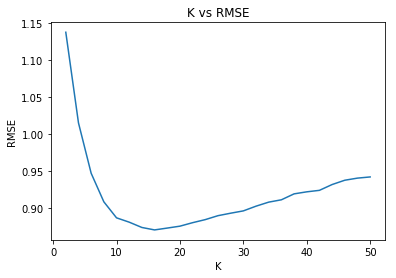

In [57]:
plt.plot(np.arange(2,52,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 20
Design a NNMF collaborative lter to predict the ratings of the
movies in the unpopular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to
50 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [58]:
kf = KFold(n_splits=10)
rmse_list = list()

for k in np.arange(2,52,2):
    print(k)
    rmse = 0
    mae = 0
    algo = NMF(n_factors = k, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        keys_to_delete = trim_data(testset, 'more')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        predictions = algo.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


0.9880293473602044


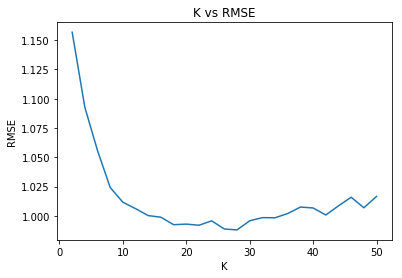

In [59]:
plt.plot(np.arange(2,52,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 21
Design a NNMF collaborative lter to predict the ratings of the
movies in the high variance movie trimmed test set and evaluate it's perfor-
mance using 10-fold cross validation. Sweep k (number of latent factors) from 2
to 50 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [60]:
kf = KFold(n_splits=10)
rmse_list = list()

for k in np.arange(2,52,2):
    print(k)
    rmse = 0
    mae = 0
    algo = NMF(n_factors = k, verbose=False)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        keys_to_delete = trim_data(testset, 'variance')
        testset = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        predictions = algo.test(testset)
        rmse += accuracy.rmse(predictions, verbose = False)
    rmse /= 10
    rmse_list.append(rmse)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


1.3665525370544755


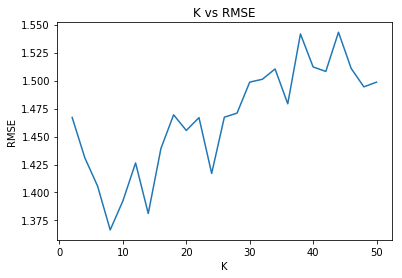

In [61]:
plt.plot(np.arange(2,52,2),rmse_list)
plt.title('K vs RMSE')
plt.xlabel('K')
plt.ylabel('RMSE')
print(np.amin(rmse_list))

# Question 22
Plot the ROC curves for the NNMF-based collaborative lter
designed in question 17 for threshold values [2:5; 3; 3:5; 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 18. For each of
the plots, also report the area under the curve (AUC) value.

In [100]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines = 1)

data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)
algo_NMF = NMF(n_factors = 18, verbose=True)
trainset, testset = train_test_split(data, test_size=.1)
algo_NMF.fit(trainset)
predictions_NMF = algo_NMF.test(testset)
predicted_NMF = [i.est for i in predictions_NMF]
true_25 = convert_predictions_for_ROC(predictions_NMF, 2.5)
true_3 = convert_predictions_for_ROC(predictions_NMF, 3)
true_35 = convert_predictions_for_ROC(predictions_NMF, 3.5)
true_4 = convert_predictions_for_ROC(predictions_NMF, 4)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


0.7672953441655048


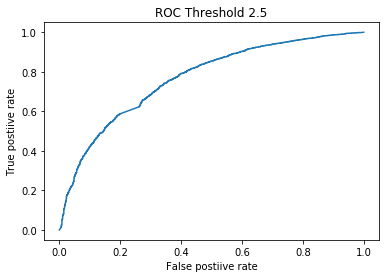

In [101]:
fpr, tpr, _ = metrics.roc_curve(true_25, predicted_NMF)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 2.5')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr, tpr))

0.7722796750733076


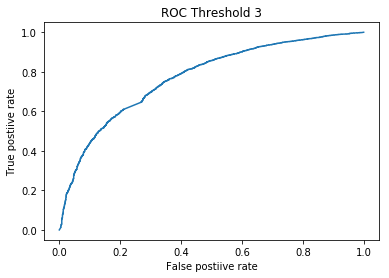

In [102]:
fpr, tpr, _ = metrics.roc_curve(true_3, predicted_NMF)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 3')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

0.7613905594702324


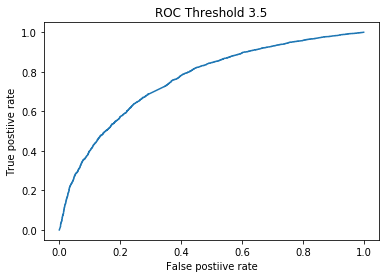

In [103]:
fpr, tpr, _ = metrics.roc_curve(true_35, predicted_NMF)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 3.5')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

0.7616785273386322


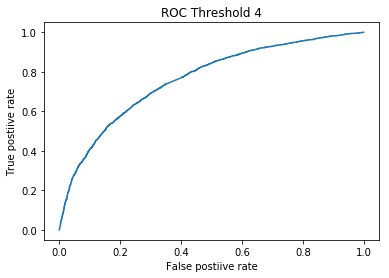

In [104]:
fpr, tpr, _ = metrics.roc_curve(true_4, predicted_NMF)
plt.plot(fpr, tpr)
plt.title('ROC Threshold 4')
plt.xlabel('False postiive rate')
plt.ylabel('True postiive rate')
print(metrics.auc(fpr,tpr))

In [66]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines = 1)

data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader=reader)
algo = NMF(n_factors = 20, verbose=True)
trainset = data.build_full_trainset()
algo.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49


# Question 23
Perform Non-negative matrix factorization on the ratings matrix
R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k
= 20). For each column of V , sort the movies in descending order and report
the genres of the top 10 movies. Do the top 10 movies belong to a particular
or a small collection of genre? Is there a connection between the latent factors
and the movie genres?

In [67]:
movies = pd.read_csv('ml-latest-small/movies.csv')

In [68]:
def list_of_genres(number_you_want):
    genres = list()
    v_0 = algo.qi[:,number_you_want]
    top_10_0 = (-v_0).argsort()[:10]
    for i in top_10_0:
        genres.append(movies.loc[i]['genres'])
    return genres

In [69]:
genre_dict = {}
for i in range(10):
    genre_dict['v' + str(i)] = list_of_genres(i)
    print(genre_dict['v'+str(i)])


['Documentary', 'Action|Horror|Sci-Fi|Thriller', 'Action|Sci-Fi|Thriller', 'Horror|Thriller', 'Adventure|Children|Comedy|Mystery', 'Drama', 'Animation|Children|Fantasy', 'Drama', 'Drama', 'Drama|Romance']
['Comedy', 'Crime|Drama|Thriller', 'Documentary', 'Action|Adventure|Fantasy', 'Crime|Drama', 'Comedy', 'Comedy|Crime', 'Comedy', 'Action|Comedy|Romance', 'Action|Adventure|Sci-Fi']
['Drama', 'Drama|Mystery|Thriller', 'Drama|Romance', 'Horror', 'Horror|Sci-Fi', 'Action|Adventure|Animation|Children|Comedy|Fantasy', 'Drama|Musical|Romance', 'Comedy|Romance', 'Documentary|Drama', 'Animation|Children|Drama']
['Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy|Romance', 'Action|Comedy|Crime|Thriller', 'Adventure|Children|Comedy|Mystery', 'Film-Noir|Thriller', 'Drama|Horror|Thriller', 'Comedy|Crime', 'Drama', 'Drama']
['Drama', 'Drama|Mystery|Thriller', 'Comedy', 'Documentary|Mystery', 'Drama', 'Drama', 'Comedy|Drama|Romance', 'Action|Mystery', 'Horror', 'Adventure|Comedy|Drama']
['Children|C

# Question 24

Design a MF with bias collaborative lter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

In [70]:
file = "ml-latest-small/ratings.csv"
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file, reader=reader)

In [71]:
from surprise.prediction_algorithms import SVD
ks = range(2,51,2)
MAEs = []
RMSEs = []
minMAE = 1000
minRMSE = 1000
minMAEk = -1
minRMSEk = -1

for k in ks:
    print("K",k)
    svd_r = cross_validate(SVD(n_factors = k, biased = True), data, measures=[u'rmse', u'mae'], cv=10, return_train_measures=False, n_jobs= -1, verbose=True)
    avg_MAE = np.mean(svd_r['test_mae'])
    avg_RMSE = np.mean(svd_r['test_rmse'])
    MAEs.append(avg_MAE)
    RMSEs.append(avg_RMSE)
    minMAE = min(minMAE,avg_MAE)
    minRMSE = min(minRMSE,avg_RMSE)
    minMAEk = (MAEs.index(minMAE) + 1) * 2
    minRMSEk = (RMSEs.index(minRMSE) + 1) * 2

K 2
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8579  0.8689  0.8703  0.8724  0.8606  0.8796  0.8662  0.8685  0.8674  0.8620  0.8674  0.0059  
MAE (testset)     0.6601  0.6689  0.6708  0.6682  0.6616  0.6757  0.6615  0.6696  0.6662  0.6588  0.6661  0.0052  
Fit time          1.09    1.09    1.09    1.09    1.11    1.09    1.11    1.13    1.15    1.07    1.10    0.02    
Test time         0.07    0.06    0.06    0.07    0.06    0.06    0.06    0.07    0.07    0.06    0.06    0.00    
K 4
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8653  0.8677  0.8626  0.8515  0.8776  0.8761  0.8686  0.8645  0.8652  0.8671  0.8666  0.0068  
MAE (testset)     0.6667  0.6673  0.6649  0.6525  0.6733  0.6727  0.6650  0.6

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8689  0.8676  0.8661  0.8658  0.8549  0.8596  0.8677  0.8590  0.8754  0.8609  0.8646  0.0057  
MAE (testset)     0.6659  0.6629  0.6663  0.6660  0.6579  0.6629  0.6655  0.6574  0.6730  0.6619  0.6640  0.0043  
Fit time          2.50    2.75    2.90    3.09    3.05    2.97    2.90    3.01    2.55    2.04    2.78    0.31    
Test time         0.10    0.11    0.11    0.12    0.11    0.12    0.11    0.10    0.07    0.07    0.10    0.02    
K 30
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8655  0.8736  0.8648  0.8670  0.8561  0.8654  0.8572  0.8694  0.8665  0.8719  0.8657  0.0053  
MAE (testset)     0.6655  0.6679  0.6623  0.6654  0.6571  0.6620  0.6624  0.6704

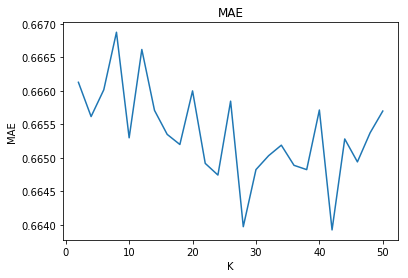

In [73]:
plt.plot(ks, MAEs)
plt.title("MAE")
plt.xlabel('K')
plt.ylabel('MAE')
plt.show()

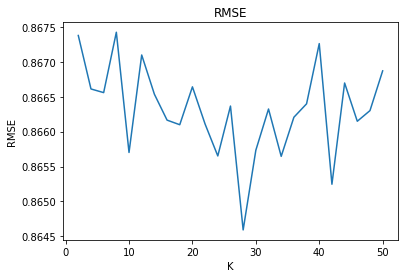

In [74]:
plt.plot(ks, RMSEs)
plt.title("RMSE")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

# Question 25
Use the plot from question 24, to nd the optimal number of
latent factors. Optimal number of latent factors is the value of k that gives
the minimum average RMSE or the minimum average MAE. Please report the
minimum average RMSE and MAE.

In [75]:
print("Selected latent factors k by MAE: ", str(minMAEk))
print("Minimum average MAE",str(minMAE))
print("Selected latent factors k by RMSE:" , str(minRMSEk))
print("Minimum average RMSE:",str(minRMSE))

Selected latent factors k by MAE:  42
Minimum average MAE 0.663925636234687
Selected latent factors k by RMSE: 28
Minimum average RMSE: 0.8645905588627626


# Question 26, 27, 28
Design a MF with bias collaborative lter to predict the ratings of
the movies in the popular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to
50 in step sizes of 2, and for each k compute the average RMSE obtained by
averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k
(X-axis). Also, report the minimum average RMSE

In [76]:
kf = KFold(n_splits=10)

rmse_popular = []
rmse_unpopular = []
rmse_variance = []

for k in np.arange(2,51,2):
    print(k)
    rmse = 0
    mae = 0
    acc_popular = []
    acc_unpopular = []
    acc_variance = []
    
    algo = SVD(n_factors=k, biased=True)
    for trainset, testset in kf.split(data):
        testdict = {}
        vardict = {}
        algo.fit(trainset)
        
        keys_to_delete = trim_data(testset, 'less')
        popular_set = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        prediction_popular = algo.test(popular_set)
        acc_popular.append(accuracy.rmse(prediction_popular, verbose = False))
        
        keys_to_delete = trim_data(testset, 'more')
        unpopular_set = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
        prediction_unpopular = algo.test(unpopular_set)
        acc_unpopular.append(accuracy.rmse(prediction_unpopular, verbose = False))
        
        keys_to_keep = trim_data(testset, 'variance')
        high_variance_set = [v for i,v in enumerate(testset) if v[1] in keys_to_keep]
        predictions_variance = algo.test(high_variance_set)
        acc_variance.append(accuracy.rmse(predictions_variance, verbose = False))
        
    rmse_popular.append(np.mean(acc_popular))
    rmse_unpopular.append(np.mean(acc_unpopular))
    rmse_variance.append(np.mean(acc_variance))

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


In [77]:
print("Minimum RMSE obtained for popular movies trimmed test set:",min(rmse_popular))
print("Minimum RMSE obtained for unpopular movies trimmed test set:",min(rmse_unpopular))
print("Minimum RMSE obtained for high variance movies trimmed test set:" ,min(rmse_variance))


Minimum RMSE obtained for popular movies trimmed test set: 0.8467181789247465
Minimum RMSE obtained for unpopular movies trimmed test set: 0.9006549806534947
Minimum RMSE obtained for high variance movies trimmed test set: 1.3644969767721034


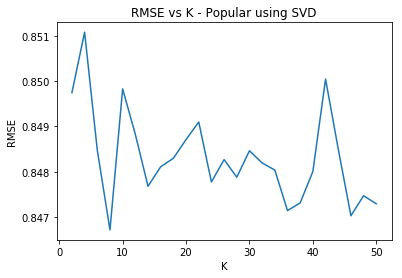

In [78]:
plt.plot(ks, rmse_popular)
plt.title("RMSE vs K - Popular using SVD")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

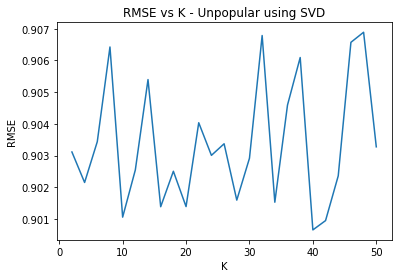

In [79]:
plt.plot(ks, rmse_unpopular)
plt.title("RMSE vs K - Unpopular using SVD")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

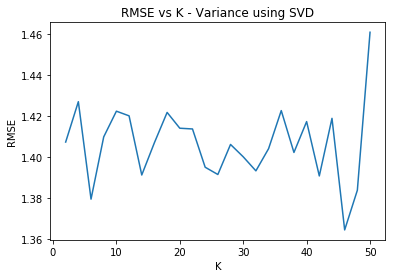

In [80]:
plt.plot(ks, rmse_variance)
plt.title("RMSE vs K - Variance using SVD")
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

# Question 29
Plot the ROC curves for the MF with bias collaborative lter
designed in question 24 for threshold values [2.5; 3; 3.5; 4]. For the ROC plot-
ting use the optimal number of latent factors found in question 25. For each of
the plots, also report the area under the curve (AUC) value.

In [81]:
def roc_plotting(classifier, predicted_class, test_class):
    fpr,tpr,thresholds= metrics.roc_curve(test_class, predicted_class, drop_intermediate=False)# finding fpr and tpr
    roc_auc= metrics.auc(fpr,tpr)#graph based on AUC
    plt.figure()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(classifier + " ROC")
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

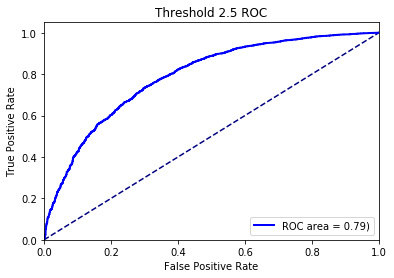

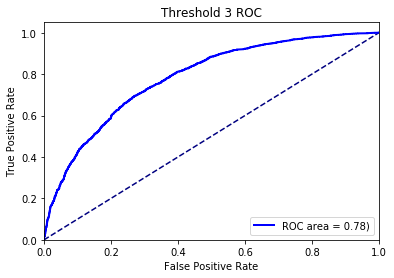

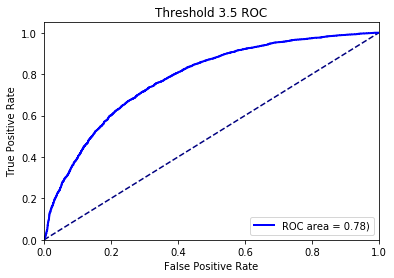

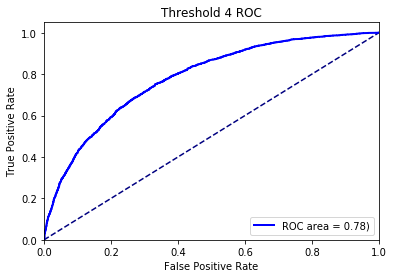

In [106]:
thresholds = [2.5, 3, 3.5, 4]
file = "ml-latest-small/ratings.csv"
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file, reader=reader)

for threshold in thresholds:
    train_set, test_set = train_test_split(data, test_size=0.1)
    algo_MF = SVD(n_factors=28, biased=True)
    algo_MF.fit(train_set)
    predictions_MF = algo_MF.test(test_set)
    y_true = [0 if getattr(row, 'r_ui') < threshold else 1 for row in predictions_MF]
    predicted_MF = [getattr(row, 'est') for row in predictions_MF]
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_MF)
    roc_plotting('Threshold ' + str(threshold), predicted_MF, y_true)


AttributeError: 'list' object has no attribute 'head'

# Question 30

Design a naive collaborative filter to predict the ratings of the
movies in the MovieLens dataset and evaluate it's performance using 10-fold
cross validation. Compute the average RMSE by averaging the RMSE across
all 10 folds. Report the average RMSE.

Note that in this case, when performing the cross-validation, there is no need to
calculate i's for the training folds each time. You are only asked to use a single set of i's calculated on the entire dataset and validate on 10 validation folds.

In [83]:
file = "ml-latest-small/ratings.csv"
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file, reader=reader)

In [84]:
from surprise import AlgoBase

class NaiveFilter(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
        
    def estimate(self, u, i):
        #return self.mean
        mean = np.mean([r for (_, r) in self.trainset.ur[u]])
        return mean

In [85]:
algo = NaiveFilter()
cv_model = cross_validate(algo, data, measures=['RMSE'], cv=10)
rmse = np.mean(cv_model['test_rmse'])


In [86]:
rmse

0.9410651349613325

# Question 31, 32, 33

Design a naive collaborative filter to predict the ratings of the
movies in the popular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Compute the average RMSE by averaging the
RMSE across all 10 folds. Report the average RMSE.

Design a naive collaborative filter to predict the ratings of the
movies in the unpopular movie trimmed test set and evaluate it's performance
using 10-fold cross validation. Compute the average RMSE by averaging the
RMSE across all 10 folds. Report the average RMSE.

Design a naive collaborative filter to predict the ratings of the
movies in the high variance movie trimmed test set and evaluate it's perfor-
mance using 10-fold cross validation. Compute the average RMSE by averaging
the RMSE across all 10 folds. Report the average RMSE.

In [87]:
kf = KFold(n_splits=10)

acc_popular = []
acc_unpopular = []
acc_variance = []

algo = NaiveFilter()
for trainset, testset in kf.split(data):
    testdict = {}
    vardict = {}
    algo.fit(trainset)

    keys_to_delete = trim_data(testset, 'less')
    popular_set = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
    prediction_popular = algo.test(popular_set)
    acc_popular.append(accuracy.rmse(prediction_popular, verbose = False))

    keys_to_delete = trim_data(testset, 'more')
    unpopular_set = [v for i,v in enumerate(testset) if v[1] in keys_to_delete]
    prediction_unpopular = algo.test(unpopular_set)
    acc_unpopular.append(accuracy.rmse(prediction_unpopular, verbose = False))

    keys_to_keep = trim_data(testset, 'variance')
    high_variance_set = [v for i,v in enumerate(testset) if v[1] in keys_to_keep]
    predictions_variance = algo.test(high_variance_set)
    acc_variance.append(accuracy.rmse(predictions_variance, verbose = False))

rmse_popular = np.mean(acc_popular)
rmse_unpopular = np.mean(acc_unpopular)
rmse_variance = np.mean(acc_variance)

In [88]:
print("Average RMSE obtained for popular movies trimmed test set:", (rmse_popular))
print("Average RMSE obtained for unpopular movies trimmed test set:",(rmse_unpopular))
print("Average RMSE obtained for high variance movies trimmed test set:",(rmse_variance))


Average RMSE obtained for popular movies trimmed test set: 0.93115072901486
Average RMSE obtained for unpopular movies trimmed test set: 0.9620223796216845
Average RMSE obtained for high variance movies trimmed test set: 1.4337766457204806


# Question 34: 
Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.


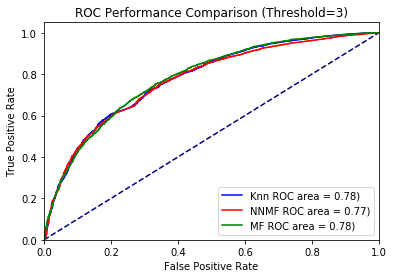

In [107]:
plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Performance Comparison (Threshold=3)")
#knn plot
true_3 = convert_predictions_for_ROC(predictions_knn, 3)
fpr, tpr, threshold = metrics.roc_curve(true_3, predicted_knn)
roc_auc= metrics.auc(fpr,tpr)#graph based on AUC
plt.plot(fpr, tpr, color='blue', lw=1.5, label='Knn ROC area = %0.2f)' % roc_auc)
#nnmf plot
true_3 = convert_predictions_for_ROC(predictions_NMF, 3)
fpr, tpr, threshold = metrics.roc_curve(true_3, predicted_NMF)
roc_auc= metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='red', lw=1.5, label='NNMF ROC area = %0.2f)' % roc_auc)
#mf plot
fpr, tpr, threshold = metrics.roc_curve(y_true, predicted_MF)
roc_auc= metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, color='green', lw=1.5, label='MF ROC area = %0.2f)' % roc_auc)

plt.legend(loc="lower right")
plt.show()


# Question 35: 
Precision and Recall are defined by the mathematical expres- sions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words

# Question 36,37,38:
Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using k-NN,NNMF,MF collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.

In [263]:
def precision_recall_at_t(predictions, t, threshold=3):  
    '''Return precision and recall at k metrics for each user.'''
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid,_,u_ri,est,_ in predictions:
        user_est_true[uid].append((est, u_ri))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        #if len(user_ratings)<t:
          #  break
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of actual items
        n_actual = sum((r_ui >= threshold) for (_,r_ui) in user_ratings)
        
        #if n_actual==0:
         #   break
        # Number of recommended items in top t
        n_rec_t = sum((est >= threshold) for (est, _) in user_ratings[:t])
        
        # Number of relevant and recommended items in top t
        n_actual_and_rec_t = sum(((r_ui >= threshold) and (est >= threshold))
                              for (est, r_ui) in user_ratings[:t])
        
        
        # Precision@t: Proportion of recommended items that are actual
        precisions[uid] = n_actual_and_rec_t / n_rec_t if n_rec_t != 0 else 1

        # Recall@t: Proportion of relevant items that are recommended
        recalls[uid] = n_actual_and_rec_t / n_actual if n_actual != 0 else 1
        
    return precisions, recalls




In [264]:

def Ranking_Precision_Recall(algo,data,threshold=3):
    kf = KFold(n_splits=10)
    averagePrecision_over_t = []
    averageRecall_over_t = []
    
    for t in range(1,26):
        averagePrecisions_eachFold = []
        averageRecalls_eachFold = []
        i=0
        for trainset, testset in kf.split(data):
            i+=1
            algo.fit(trainset)
            predictions = algo.test(testset)
            precisions, recalls = precision_recall_at_t(predictions, t=t, threshold=3)
        
            averagePrecisions_eachFold.append(sum(p for p in precisions.values())/float(len(precisions)))
            averageRecalls_eachFold.append(sum(r for r in recalls.values())/float(len(recalls)))
            print("Avg Precision in fold %d :" %i,averagePrecisions_eachFold)
            print("Avg Recall in fold %d :" %i,averageRecalls_eachFold)
        averagePrecision_over_t.append(sum(averagePrecisions_eachFold)/float(len(averagePrecisions_eachFold)))
        averageRecall_over_t.append(sum(averageRecalls_eachFold)/float(len(averageRecalls_eachFold)))
    return averagePrecision_over_t, averageRecall_over_t

   

In [265]:
file = "ml-latest-small/ratings.csv"
reader = Reader(line_format = 'user item rating timestamp', sep = ',', rating_scale = (0.5, 5), skip_lines=1)
data = Dataset.load_from_file(file, reader=reader)
sim_options = {'name': 'pearson'}

precision_knn, recall_knn = Ranking_Precision_Recall(KNNWithMeans(k=28, sim_options=sim_options, verbose=False), data=data, threshold=3)
print("Avg Precision knn",precision_knn)
print("Avg Recall knn" ,recall_knn)
precision_NMF, recall_NMF = Ranking_Precision_Recall(NMF(n_factors=18, biased=False), data=data, threshold=3)
print("Avg Precision NMF",precision_NMF)
print("Avg Recall NMF" ,recall_NMF)
precision_MF, recall_MF = Ranking_Precision_Recall(SVD(n_factors=28, biased=True), data=data, threshold=3)
print("Avg Precision MF",precision_MF)
print("Avg Precision MF" ,recall_MF)
    


Avg Precision in fold 1 : [0.9243697478991597]
Avg Recall in fold 1 : [0.22541093699516518]
Avg Precision in fold 2 : [0.9243697478991597, 0.9294117647058824]
Avg Recall in fold 2 : [0.22541093699516518, 0.2101330212064333]
Avg Precision in fold 3 : [0.9243697478991597, 0.9294117647058824, 0.9345637583892618]
Avg Recall in fold 3 : [0.22541093699516518, 0.2101330212064333, 0.2117028912482384]
Avg Precision in fold 4 : [0.9243697478991597, 0.9294117647058824, 0.9345637583892618, 0.9183333333333333]
Avg Recall in fold 4 : [0.22541093699516518, 0.2101330212064333, 0.2117028912482384, 0.21364339702792126]
Avg Precision in fold 5 : [0.9243697478991597, 0.9294117647058824, 0.9345637583892618, 0.9183333333333333, 0.9230769230769231]
Avg Recall in fold 5 : [0.22541093699516518, 0.2101330212064333, 0.2117028912482384, 0.21364339702792126, 0.22482506023047483]
Avg Precision in fold 6 : [0.9243697478991597, 0.9294117647058824, 0.9345637583892618, 0.9183333333333333, 0.9230769230769231, 0.91750841

Avg Precision in fold 2 : [0.9222314969393433, 0.9197582911748174]
Avg Recall in fold 2 : [0.5364072585889946, 0.5470253647955686]
Avg Precision in fold 3 : [0.9222314969393433, 0.9197582911748174, 0.9078431372549021]
Avg Recall in fold 3 : [0.5364072585889946, 0.5470253647955686, 0.5462088482200812]
Avg Precision in fold 4 : [0.9222314969393433, 0.9197582911748174, 0.9078431372549021, 0.9120909595119245]
Avg Recall in fold 4 : [0.5364072585889946, 0.5470253647955686, 0.5462088482200812, 0.5423067504470312]
Avg Precision in fold 5 : [0.9222314969393433, 0.9197582911748174, 0.9078431372549021, 0.9120909595119245, 0.9180625348967056]
Avg Recall in fold 5 : [0.5364072585889946, 0.5470253647955686, 0.5462088482200812, 0.5423067504470312, 0.5431398751663152]
Avg Precision in fold 6 : [0.9222314969393433, 0.9197582911748174, 0.9078431372549021, 0.9120909595119245, 0.9180625348967056, 0.9134933774834441]
Avg Recall in fold 6 : [0.5364072585889946, 0.5470253647955686, 0.5462088482200812, 0.542

Avg Precision in fold 3 : [0.9148468815135481, 0.9101200347469, 0.9135384370776688]
Avg Recall in fold 3 : [0.6585047120195952, 0.6499295001847736, 0.6676938833918619]
Avg Precision in fold 4 : [0.9148468815135481, 0.9101200347469, 0.9135384370776688, 0.9135290389034145]
Avg Recall in fold 4 : [0.6585047120195952, 0.6499295001847736, 0.6676938833918619, 0.6573354388359486]
Avg Precision in fold 5 : [0.9148468815135481, 0.9101200347469, 0.9135384370776688, 0.9135290389034145, 0.9122698412698416]
Avg Recall in fold 5 : [0.6585047120195952, 0.6499295001847736, 0.6676938833918619, 0.6573354388359486, 0.6637446657685734]
Avg Precision in fold 6 : [0.9148468815135481, 0.9101200347469, 0.9135384370776688, 0.9135290389034145, 0.9122698412698416, 0.911339385252429]
Avg Recall in fold 6 : [0.6585047120195952, 0.6499295001847736, 0.6676938833918619, 0.6573354388359486, 0.6637446657685734, 0.6634983570564362]
Avg Precision in fold 7 : [0.9148468815135481, 0.9101200347469, 0.9135384370776688, 0.913

Avg Precision in fold 4 : [0.9011178369652951, 0.9115724288609863, 0.9066960117380285, 0.9078659316075429]
Avg Recall in fold 4 : [0.7192289195555108, 0.729762184653999, 0.7178238291848767, 0.731800988773267]
Avg Precision in fold 5 : [0.9011178369652951, 0.9115724288609863, 0.9066960117380285, 0.9078659316075429, 0.8999913589109569]
Avg Recall in fold 5 : [0.7192289195555108, 0.729762184653999, 0.7178238291848767, 0.731800988773267, 0.7192396464425873]
Avg Precision in fold 6 : [0.9011178369652951, 0.9115724288609863, 0.9066960117380285, 0.9078659316075429, 0.8999913589109569, 0.911819394424436]
Avg Recall in fold 6 : [0.7192289195555108, 0.729762184653999, 0.7178238291848767, 0.731800988773267, 0.7192396464425873, 0.7310692827883145]
Avg Precision in fold 7 : [0.9011178369652951, 0.9115724288609863, 0.9066960117380285, 0.9078659316075429, 0.8999913589109569, 0.911819394424436, 0.9054096347357582]
Avg Recall in fold 7 : [0.7192289195555108, 0.729762184653999, 0.7178238291848767, 0.731

Avg Precision in fold 5 : [0.8990027746309156, 0.8976684146852217, 0.9033035448718417, 0.9105279150429648, 0.9047980779041387]
Avg Recall in fold 5 : [0.7574310182631346, 0.7546386136882544, 0.7659907581449799, 0.74693793111493, 0.758697876715918]
Avg Precision in fold 6 : [0.8990027746309156, 0.8976684146852217, 0.9033035448718417, 0.9105279150429648, 0.9047980779041387, 0.9030498396076285]
Avg Recall in fold 6 : [0.7574310182631346, 0.7546386136882544, 0.7659907581449799, 0.74693793111493, 0.758697876715918, 0.7696980521560186]
Avg Precision in fold 7 : [0.8990027746309156, 0.8976684146852217, 0.9033035448718417, 0.9105279150429648, 0.9047980779041387, 0.9030498396076285, 0.9119881235459125]
Avg Recall in fold 7 : [0.7574310182631346, 0.7546386136882544, 0.7659907581449799, 0.74693793111493, 0.758697876715918, 0.7696980521560186, 0.7608837560678757]
Avg Precision in fold 8 : [0.8990027746309156, 0.8976684146852217, 0.9033035448718417, 0.9105279150429648, 0.9047980779041387, 0.9030498

Avg Precision in fold 6 : [0.9042822994650239, 0.9019319790950404, 0.9108284929623318, 0.9086480149294222, 0.8989957883676688, 0.8936277403152407]
Avg Recall in fold 6 : [0.7964065551302254, 0.7906747295532176, 0.7958040543535791, 0.7974985015050278, 0.7876747426121085, 0.7915700911460317]
Avg Precision in fold 7 : [0.9042822994650239, 0.9019319790950404, 0.9108284929623318, 0.9086480149294222, 0.8989957883676688, 0.8936277403152407, 0.8973516355368517]
Avg Recall in fold 7 : [0.7964065551302254, 0.7906747295532176, 0.7958040543535791, 0.7974985015050278, 0.7876747426121085, 0.7915700911460317, 0.7949829678940122]
Avg Precision in fold 8 : [0.9042822994650239, 0.9019319790950404, 0.9108284929623318, 0.9086480149294222, 0.8989957883676688, 0.8936277403152407, 0.8973516355368517, 0.9104548533210153]
Avg Recall in fold 8 : [0.7964065551302254, 0.7906747295532176, 0.7958040543535791, 0.7974985015050278, 0.7876747426121085, 0.7915700911460317, 0.7949829678940122, 0.7839110186056656]
Avg Pre

Avg Precision in fold 7 : [0.9002318505719701, 0.8994786968098403, 0.8931836950965295, 0.9058718779357327, 0.888279947599414, 0.8929323918054344, 0.8952325333241137]
Avg Recall in fold 7 : [0.8052213793818244, 0.8055184560136506, 0.8020633290753089, 0.8052185278279722, 0.8157553523081832, 0.8083454747439669, 0.8071636915051412]
Avg Precision in fold 8 : [0.9002318505719701, 0.8994786968098403, 0.8931836950965295, 0.9058718779357327, 0.888279947599414, 0.8929323918054344, 0.8952325333241137, 0.9079621121113555]
Avg Recall in fold 8 : [0.8052213793818244, 0.8055184560136506, 0.8020633290753089, 0.8052185278279722, 0.8157553523081832, 0.8083454747439669, 0.8071636915051412, 0.8091844431908045]
Avg Precision in fold 9 : [0.9002318505719701, 0.8994786968098403, 0.8931836950965295, 0.9058718779357327, 0.888279947599414, 0.8929323918054344, 0.8952325333241137, 0.9079621121113555, 0.8966279220388236]
Avg Recall in fold 9 : [0.8052213793818244, 0.8055184560136506, 0.8020633290753089, 0.80521852

Avg Precision in fold 8 : [0.9032839138243082, 0.8917693974483835, 0.8945966904408142, 0.8939343351175252, 0.9086297264325519, 0.8931043165526716, 0.9075892942586197, 0.9007578442655851]
Avg Recall in fold 8 : [0.8207858568830533, 0.8196888658974035, 0.8212699593995635, 0.827350503221918, 0.824844695774612, 0.8193050214718983, 0.8161907999737755, 0.832959577877328]
Avg Precision in fold 9 : [0.9032839138243082, 0.8917693974483835, 0.8945966904408142, 0.8939343351175252, 0.9086297264325519, 0.8931043165526716, 0.9075892942586197, 0.9007578442655851, 0.8972318073515817]
Avg Recall in fold 9 : [0.8207858568830533, 0.8196888658974035, 0.8212699593995635, 0.827350503221918, 0.824844695774612, 0.8193050214718983, 0.8161907999737755, 0.832959577877328, 0.8203953986995972]
Avg Precision in fold 10 : [0.9032839138243082, 0.8917693974483835, 0.8945966904408142, 0.8939343351175252, 0.9086297264325519, 0.8931043165526716, 0.9075892942586197, 0.9007578442655851, 0.8972318073515817, 0.89669494897181

Avg Precision in fold 9 : [0.8963143054505852, 0.90197169924649, 0.9024162756459454, 0.898827549133821, 0.9034215148891286, 0.901247828420418, 0.8916261392615323, 0.9018570105553769, 0.8925616277734972]
Avg Recall in fold 9 : [0.8366704251405283, 0.8204651366268402, 0.8330233937739698, 0.836529647462362, 0.8414198076579024, 0.8353289138315011, 0.8341118846613713, 0.8346784007871197, 0.8292708791385189]
Avg Precision in fold 10 : [0.8963143054505852, 0.90197169924649, 0.9024162756459454, 0.898827549133821, 0.9034215148891286, 0.901247828420418, 0.8916261392615323, 0.9018570105553769, 0.8925616277734972, 0.9064090147265604]
Avg Recall in fold 10 : [0.8366704251405283, 0.8204651366268402, 0.8330233937739698, 0.836529647462362, 0.8414198076579024, 0.8353289138315011, 0.8341118846613713, 0.8346784007871197, 0.8292708791385189, 0.8327043120723518]
Avg Precision knn [0.9246106094378348, 0.9236916324445467, 0.9180423451915394, 0.9165760377089143, 0.9148794711664596, 0.9115389034479808, 0.91103

Avg Precision in fold 7 : [0.9194352159468446, 0.9254606365159138, 0.9143016138007793, 0.9154187465335559, 0.924040066777964, 0.9103852596314913, 0.9067226890756305]
Avg Recall in fold 7 : [0.47258587325839774, 0.46429982880971116, 0.46673323130127853, 0.46148367363642606, 0.46032477697621266, 0.48364014151459583, 0.4730088457533933]
Avg Precision in fold 8 : [0.9194352159468446, 0.9254606365159138, 0.9143016138007793, 0.9154187465335559, 0.924040066777964, 0.9103852596314913, 0.9067226890756305, 0.9129104062326108]
Avg Recall in fold 8 : [0.47258587325839774, 0.46429982880971116, 0.46673323130127853, 0.46148367363642606, 0.46032477697621266, 0.48364014151459583, 0.4730088457533933, 0.45212339784225697]
Avg Precision in fold 9 : [0.9194352159468446, 0.9254606365159138, 0.9143016138007793, 0.9154187465335559, 0.924040066777964, 0.9103852596314913, 0.9067226890756305, 0.9129104062326108, 0.9187465335551863]
Avg Recall in fold 9 : [0.47258587325839774, 0.46429982880971116, 0.4667332313012

Avg Precision in fold 8 : [0.9073545861297538, 0.9071666666666665, 0.91725, 0.9071548821548826, 0.9111669458403128, 0.9122499999999999, 0.9070395102949356, 0.9010329424902292]
Avg Recall in fold 8 : [0.6205876763520444, 0.6274719301347508, 0.6283783986644239, 0.6262405369224009, 0.6263810182303648, 0.6307855208663602, 0.6160960503521412, 0.6245090347021899]
Avg Precision in fold 9 : [0.9073545861297538, 0.9071666666666665, 0.91725, 0.9071548821548826, 0.9111669458403128, 0.9122499999999999, 0.9070395102949356, 0.9010329424902292, 0.9071586511885019]
Avg Recall in fold 9 : [0.6205876763520444, 0.6274719301347508, 0.6283783986644239, 0.6262405369224009, 0.6263810182303648, 0.6307855208663602, 0.6160960503521412, 0.6245090347021899, 0.6326158937201711]
Avg Precision in fold 10 : [0.9073545861297538, 0.9071666666666665, 0.91725, 0.9071548821548826, 0.9111669458403128, 0.9122499999999999, 0.9070395102949356, 0.9010329424902292, 0.9071586511885019, 0.8994526546250686]
Avg Recall in fold 10 :

Avg Precision in fold 9 : [0.905884009009009, 0.906639015181729, 0.907614253755193, 0.9163473357917803, 0.9059424932763809, 0.8902447645724958, 0.8964338100476723, 0.9054226223380459, 0.9075686382900313]
Avg Recall in fold 9 : [0.6997582257262923, 0.7020063684287917, 0.7104718532155306, 0.7031728971230322, 0.7025546486558059, 0.6890151300805158, 0.7092383033982564, 0.7073541567466032, 0.6980793292016279]
Avg Precision in fold 10 : [0.905884009009009, 0.906639015181729, 0.907614253755193, 0.9163473357917803, 0.9059424932763809, 0.8902447645724958, 0.8964338100476723, 0.9054226223380459, 0.9075686382900313, 0.902088310240485]
Avg Recall in fold 10 : [0.6997582257262923, 0.7020063684287917, 0.7104718532155306, 0.7031728971230322, 0.7025546486558059, 0.6890151300805158, 0.7092383033982564, 0.7073541567466032, 0.6980793292016279, 0.70330444824192]
Avg Precision in fold 1 : [0.9139743487823625]
Avg Recall in fold 1 : [0.7275121969551616]
Avg Precision in fold 2 : [0.9139743487823625, 0.90140

Avg Precision in fold 10 : [0.9005188510222071, 0.9028656466886854, 0.9008062648687651, 0.893504321765191, 0.9090413660413659, 0.9006656602034757, 0.9042841801978017, 0.8895070265286575, 0.9017269197801648, 0.9055994519019732]
Avg Recall in fold 10 : [0.7577976438529328, 0.745031624143326, 0.751303340492774, 0.7335779277235159, 0.7441233146321438, 0.7394649342113215, 0.7392725096783884, 0.7349527947304705, 0.7432666188644023, 0.7503934123695934]
Avg Precision in fold 1 : [0.9182103326093313]
Avg Recall in fold 1 : [0.7652628721966063]
Avg Precision in fold 2 : [0.9182103326093313, 0.9116003575802573]
Avg Recall in fold 2 : [0.7652628721966063, 0.7530125902841854]
Avg Precision in fold 3 : [0.9182103326093313, 0.9116003575802573, 0.9088758046115905]
Avg Recall in fold 3 : [0.7652628721966063, 0.7530125902841854, 0.7435872707810952]
Avg Precision in fold 4 : [0.9182103326093313, 0.9116003575802573, 0.9088758046115905, 0.9019606440460715]
Avg Recall in fold 4 : [0.7652628721966063, 0.7530

Avg Precision in fold 1 : [0.8988095422175032]
Avg Recall in fold 1 : [0.7883617533662174]
Avg Precision in fold 2 : [0.8988095422175032, 0.8959348363563728]
Avg Recall in fold 2 : [0.7883617533662174, 0.7868572749890543]
Avg Precision in fold 3 : [0.8988095422175032, 0.8959348363563728, 0.9147827256495601]
Avg Recall in fold 3 : [0.7883617533662174, 0.7868572749890543, 0.8020591054281999]
Avg Precision in fold 4 : [0.8988095422175032, 0.8959348363563728, 0.9147827256495601, 0.9032795038667525]
Avg Recall in fold 4 : [0.7883617533662174, 0.7868572749890543, 0.8020591054281999, 0.7865505769486809]
Avg Precision in fold 5 : [0.8988095422175032, 0.8959348363563728, 0.9147827256495601, 0.9032795038667525, 0.8968310394854638]
Avg Recall in fold 5 : [0.7883617533662174, 0.7868572749890543, 0.8020591054281999, 0.7865505769486809, 0.7860692582417872]
Avg Precision in fold 6 : [0.8988095422175032, 0.8959348363563728, 0.9147827256495601, 0.9032795038667525, 0.8968310394854638, 0.9092207489056233

Avg Precision in fold 3 : [0.901131928579846, 0.909203688948078, 0.898284466300527]
Avg Recall in fold 3 : [0.802967036700655, 0.8110035239599284, 0.792929343447978]
Avg Precision in fold 4 : [0.901131928579846, 0.909203688948078, 0.898284466300527, 0.904127057241709]
Avg Recall in fold 4 : [0.802967036700655, 0.8110035239599284, 0.792929343447978, 0.8138613909561406]
Avg Precision in fold 5 : [0.901131928579846, 0.909203688948078, 0.898284466300527, 0.904127057241709, 0.8994198689655388]
Avg Recall in fold 5 : [0.802967036700655, 0.8110035239599284, 0.792929343447978, 0.8138613909561406, 0.8026034283379485]
Avg Precision in fold 6 : [0.901131928579846, 0.909203688948078, 0.898284466300527, 0.904127057241709, 0.8994198689655388, 0.8905236459857757]
Avg Recall in fold 6 : [0.802967036700655, 0.8110035239599284, 0.792929343447978, 0.8138613909561406, 0.8026034283379485, 0.789483402170558]
Avg Precision in fold 7 : [0.901131928579846, 0.909203688948078, 0.898284466300527, 0.90412705724170

Avg Precision in fold 4 : [0.8987298486973411, 0.8947929364213111, 0.9032275455334499, 0.8997031055741418]
Avg Recall in fold 4 : [0.8234580462497525, 0.8173483551887798, 0.8166200765602117, 0.8134069477424942]
Avg Precision in fold 5 : [0.8987298486973411, 0.8947929364213111, 0.9032275455334499, 0.8997031055741418, 0.8916165808921308]
Avg Recall in fold 5 : [0.8234580462497525, 0.8173483551887798, 0.8166200765602117, 0.8134069477424942, 0.8133290473664112]
Avg Precision in fold 6 : [0.8987298486973411, 0.8947929364213111, 0.9032275455334499, 0.8997031055741418, 0.8916165808921308, 0.9049797216335321]
Avg Recall in fold 6 : [0.8234580462497525, 0.8173483551887798, 0.8166200765602117, 0.8134069477424942, 0.8133290473664112, 0.8140108480758594]
Avg Precision in fold 7 : [0.8987298486973411, 0.8947929364213111, 0.9032275455334499, 0.8997031055741418, 0.8916165808921308, 0.9049797216335321, 0.9019846726716119]
Avg Recall in fold 7 : [0.8234580462497525, 0.8173483551887798, 0.81662007656021

Avg Precision in fold 5 : [0.9023678288818776, 0.8902800779104291, 0.9056659515175107, 0.8991905122115694, 0.8881757269560198]
Avg Recall in fold 5 : [0.8251916564240304, 0.8149770033836042, 0.8253430419733485, 0.8170521963330564, 0.8262323072797347]
Avg Precision in fold 6 : [0.9023678288818776, 0.8902800779104291, 0.9056659515175107, 0.8991905122115694, 0.8881757269560198, 0.8953523485056123]
Avg Recall in fold 6 : [0.8251916564240304, 0.8149770033836042, 0.8253430419733485, 0.8170521963330564, 0.8262323072797347, 0.8297929546394505]
Avg Precision in fold 7 : [0.9023678288818776, 0.8902800779104291, 0.9056659515175107, 0.8991905122115694, 0.8881757269560198, 0.8953523485056123, 0.8945991727716978]
Avg Recall in fold 7 : [0.8251916564240304, 0.8149770033836042, 0.8253430419733485, 0.8170521963330564, 0.8262323072797347, 0.8297929546394505, 0.8227240779398933]
Avg Precision in fold 8 : [0.9023678288818776, 0.8902800779104291, 0.9056659515175107, 0.8991905122115694, 0.8881757269560198, 

Avg Precision in fold 1 : [0.9148700939745721]
Avg Recall in fold 1 : [0.47512968386867094]
Avg Precision in fold 2 : [0.9148700939745721, 0.9288079470198681]
Avg Recall in fold 2 : [0.47512968386867094, 0.4787481382449529]
Avg Precision in fold 3 : [0.9148700939745721, 0.9288079470198681, 0.9252491694352163]
Avg Recall in fold 3 : [0.47512968386867094, 0.4787481382449529, 0.4688583142381144]
Avg Precision in fold 4 : [0.9148700939745721, 0.9288079470198681, 0.9252491694352163, 0.9144444444444453]
Avg Recall in fold 4 : [0.47512968386867094, 0.4787481382449529, 0.4688583142381144, 0.4785104284871543]
Avg Precision in fold 5 : [0.9148700939745721, 0.9288079470198681, 0.9252491694352163, 0.9144444444444453, 0.9133333333333337]
Avg Recall in fold 5 : [0.47512968386867094, 0.4787481382449529, 0.4688583142381144, 0.4785104284871543, 0.4701646553541666]
Avg Precision in fold 6 : [0.9148700939745721, 0.9288079470198681, 0.9252491694352163, 0.9144444444444453, 0.9133333333333337, 0.92171717171

Avg Precision in fold 3 : [0.9069838619922094, 0.923143495254048, 0.9125279642058169]
Avg Recall in fold 3 : [0.6421882477758276, 0.6473478745489293, 0.6426446251567255]
Avg Precision in fold 4 : [0.9069838619922094, 0.923143495254048, 0.9125279642058169, 0.906322795341098]
Avg Recall in fold 4 : [0.6421882477758276, 0.6473478745489293, 0.6426446251567255, 0.6365309829799363]
Avg Precision in fold 5 : [0.9069838619922094, 0.923143495254048, 0.9125279642058169, 0.906322795341098, 0.9209794101279909]
Avg Recall in fold 5 : [0.6421882477758276, 0.6473478745489293, 0.6426446251567255, 0.6365309829799363, 0.6392013197174886]
Avg Precision in fold 6 : [0.9069838619922094, 0.923143495254048, 0.9125279642058169, 0.906322795341098, 0.9209794101279909, 0.9211817168338907]
Avg Recall in fold 6 : [0.6421882477758276, 0.6473478745489293, 0.6426446251567255, 0.6365309829799363, 0.6392013197174886, 0.6399385663464823]
Avg Precision in fold 7 : [0.9069838619922094, 0.923143495254048, 0.912527964205816

Avg Precision in fold 4 : [0.9092717086834735, 0.9068838275432606, 0.8991442199775541, 0.908222808138916]
Avg Recall in fold 4 : [0.7259570836175026, 0.7188471263387876, 0.7272795039670316, 0.7110316230113635]
Avg Precision in fold 5 : [0.9092717086834735, 0.9068838275432606, 0.8991442199775541, 0.908222808138916, 0.9160249774380205]
Avg Recall in fold 5 : [0.7259570836175026, 0.7188471263387876, 0.7272795039670316, 0.7110316230113635, 0.7120493028480722]
Avg Precision in fold 6 : [0.9092717086834735, 0.9068838275432606, 0.8991442199775541, 0.908222808138916, 0.9160249774380205, 0.9036474589835944]
Avg Recall in fold 6 : [0.7259570836175026, 0.7188471263387876, 0.7272795039670316, 0.7110316230113635, 0.7120493028480722, 0.7054143158356899]
Avg Precision in fold 7 : [0.9092717086834735, 0.9068838275432606, 0.8991442199775541, 0.908222808138916, 0.9160249774380205, 0.9036474589835944, 0.9086981996377969]
Avg Recall in fold 7 : [0.7259570836175026, 0.7188471263387876, 0.7272795039670316, 

Avg Precision in fold 5 : [0.9035573358194393, 0.8927674394956276, 0.9073422885715245, 0.9069977753727759, 0.8954689030775989]
Avg Recall in fold 5 : [0.7682839839751147, 0.7756316133374586, 0.7619047294246193, 0.7728320258465452, 0.765966008943252]
Avg Precision in fold 6 : [0.9035573358194393, 0.8927674394956276, 0.9073422885715245, 0.9069977753727759, 0.8954689030775989, 0.9058933655829633]
Avg Recall in fold 6 : [0.7682839839751147, 0.7756316133374586, 0.7619047294246193, 0.7728320258465452, 0.765966008943252, 0.7631954824126467]
Avg Precision in fold 7 : [0.9035573358194393, 0.8927674394956276, 0.9073422885715245, 0.9069977753727759, 0.8954689030775989, 0.9058933655829633, 0.9043233845997669]
Avg Recall in fold 7 : [0.7682839839751147, 0.7756316133374586, 0.7619047294246193, 0.7728320258465452, 0.765966008943252, 0.7631954824126467, 0.7759430567212667]
Avg Precision in fold 8 : [0.9035573358194393, 0.8927674394956276, 0.9073422885715245, 0.9069977753727759, 0.8954689030775989, 0.9

Avg Precision in fold 6 : [0.9026163427993719, 0.9059432071196789, 0.9104218744218747, 0.9096628362409102, 0.8957554575054587, 0.8983776778776784]
Avg Recall in fold 6 : [0.7993362535863289, 0.7961109494596402, 0.8010323782880311, 0.7955483751225062, 0.8013647280738431, 0.7953156813479808]
Avg Precision in fold 7 : [0.9026163427993719, 0.9059432071196789, 0.9104218744218747, 0.9096628362409102, 0.8957554575054587, 0.8983776778776784, 0.9114409676702042]
Avg Recall in fold 7 : [0.7993362535863289, 0.7961109494596402, 0.8010323782880311, 0.7955483751225062, 0.8013647280738431, 0.7953156813479808, 0.7984963744157857]
Avg Precision in fold 8 : [0.9026163427993719, 0.9059432071196789, 0.9104218744218747, 0.9096628362409102, 0.8957554575054587, 0.8983776778776784, 0.9114409676702042, 0.903213180792216]
Avg Recall in fold 8 : [0.7993362535863289, 0.7961109494596402, 0.8010323782880311, 0.7955483751225062, 0.8013647280738431, 0.7953156813479808, 0.7984963744157857, 0.7971344743002245]
Avg Prec

Avg Precision in fold 7 : [0.9053058918452063, 0.908604649299503, 0.9042175834786131, 0.8974064082806329, 0.9009186930077716, 0.9088739299970371, 0.8928550005277952]
Avg Recall in fold 7 : [0.8206182700302032, 0.8195683761632301, 0.8141509706265181, 0.816505663061721, 0.8202823551475943, 0.8253106042876298, 0.8205084697670183]
Avg Precision in fold 8 : [0.9053058918452063, 0.908604649299503, 0.9042175834786131, 0.8974064082806329, 0.9009186930077716, 0.9088739299970371, 0.8928550005277952, 0.9085593082844899]
Avg Recall in fold 8 : [0.8206182700302032, 0.8195683761632301, 0.8141509706265181, 0.816505663061721, 0.8202823551475943, 0.8253106042876298, 0.8205084697670183, 0.8238118548001735]
Avg Precision in fold 9 : [0.9053058918452063, 0.908604649299503, 0.9042175834786131, 0.8974064082806329, 0.9009186930077716, 0.9088739299970371, 0.8928550005277952, 0.9085593082844899, 0.8937634570653726]
Avg Recall in fold 9 : [0.8206182700302032, 0.8195683761632301, 0.8141509706265181, 0.8165056630

Avg Precision in fold 8 : [0.8970385355344034, 0.8990083364133291, 0.9131947201215765, 0.8998310621921718, 0.9045805193036017, 0.9045987762703432, 0.8954118064498541, 0.9129144364213114]
Avg Recall in fold 8 : [0.8340265652367979, 0.8379754962297522, 0.8247350243488071, 0.8349817612985487, 0.833672239269463, 0.8272502800078702, 0.8414374265960737, 0.8368248009636481]
Avg Precision in fold 9 : [0.8970385355344034, 0.8990083364133291, 0.9131947201215765, 0.8998310621921718, 0.9045805193036017, 0.9045987762703432, 0.8954118064498541, 0.9129144364213114, 0.8890001007498829]
Avg Recall in fold 9 : [0.8340265652367979, 0.8379754962297522, 0.8247350243488071, 0.8349817612985487, 0.833672239269463, 0.8272502800078702, 0.8414374265960737, 0.8368248009636481, 0.8378561025341674]
Avg Precision in fold 10 : [0.8970385355344034, 0.8990083364133291, 0.9131947201215765, 0.8998310621921718, 0.9045805193036017, 0.9045987762703432, 0.8954118064498541, 0.9129144364213114, 0.8890001007498829, 0.9029047038

Avg Precision in fold 9 : [0.8932752476360849, 0.9062130801290113, 0.911036074890396, 0.9063578835896394, 0.9055012002794841, 0.8959396190023672, 0.9012043783821253, 0.9022576410445995, 0.8949046297478833]
Avg Recall in fold 9 : [0.850718844945566, 0.8479913783351577, 0.8535958491646091, 0.8490177704424564, 0.8418607939391505, 0.8490015961094649, 0.8476684010905593, 0.8405238618496642, 0.8431928721699053]
Avg Precision in fold 10 : [0.8932752476360849, 0.9062130801290113, 0.911036074890396, 0.9063578835896394, 0.9055012002794841, 0.8959396190023672, 0.9012043783821253, 0.9022576410445995, 0.8949046297478833, 0.8931338049358803]
Avg Recall in fold 10 : [0.850718844945566, 0.8479913783351577, 0.8535958491646091, 0.8490177704424564, 0.8418607939391505, 0.8490015961094649, 0.8476684010905593, 0.8405238618496642, 0.8431928721699053, 0.8521778278008234]
Avg Precision in fold 1 : [0.9044927303947858]
Avg Recall in fold 1 : [0.8428671071699626]
Avg Precision in fold 2 : [0.9044927303947858, 0.

In [266]:
#plotting
def Plot_Precision_Recall(y_axis,x_axis,y_label,x_label,label):
    plt.figure()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.plot(x_axis,y_axis, color='blue', lw=1.5)
    plt.show()
    


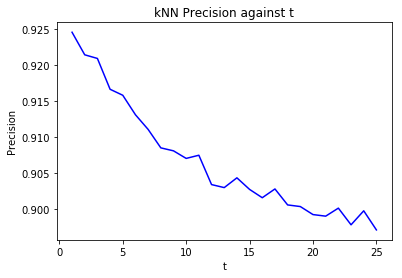

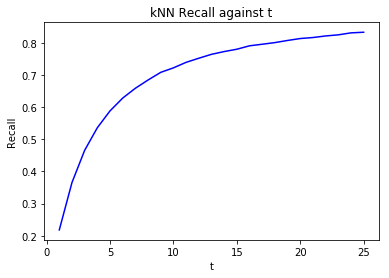

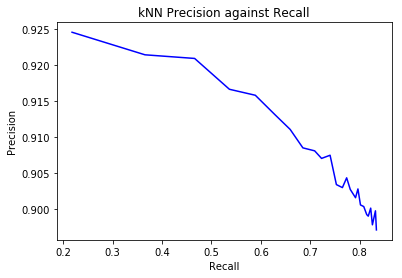

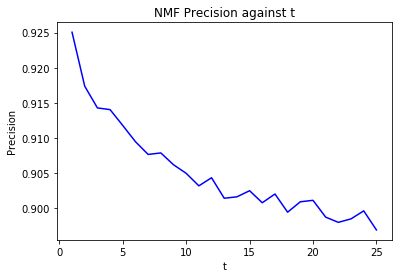

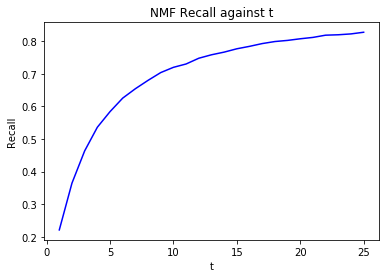

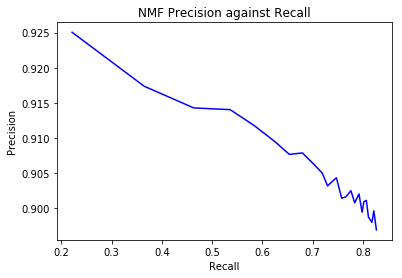

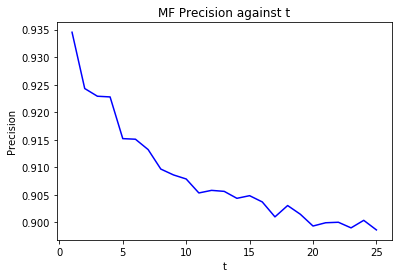

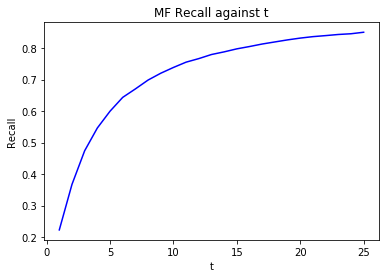

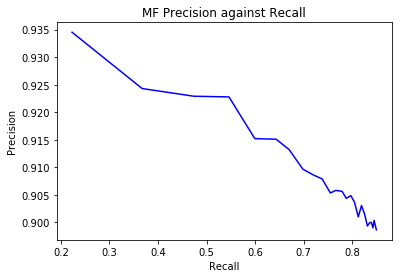

In [256]:
Plot_Precision_Recall(precision_knn,range(1,26),'Precision', 't', 'kNN Precision against t')
Plot_Precision_Recall(recall_knn,range(1,26),'Recall', 't', 'kNN Recall against t')
Plot_Precision_Recall(precision_knn, recall_knn, 'Precision','Recall','kNN Precision against Recall')
                    
Plot_Precision_Recall(precision_NMF,range(1,26),'Precision', 't', 'NMF Precision against t')
Plot_Precision_Recall(recall_NMF,range(1,26),'Recall', 't', 'NMF Recall against t')
Plot_Precision_Recall(precision_NMF,recall_NMF, 'Precision','Recall','NMF Precision against Recall')

Plot_Precision_Recall(precision_MF,range(1,26),'Precision', 't', 'MF Precision against t')
Plot_Precision_Recall(recall_MF,range(1,26),'Recall', 't', 'MF Recall against t')
Plot_Precision_Recall(precision_MF,recall_MF, 'Precision','Recall','MF Precision against Recall')


                      
                      
                      

# Question 39:
Plot the precision-recall curve obtained in questions 36,37, and 38 in the same figure. Use this figure to compare the relevance of the recom- mendation list generated using k-NN, NNMF, and MF with bias predictions.


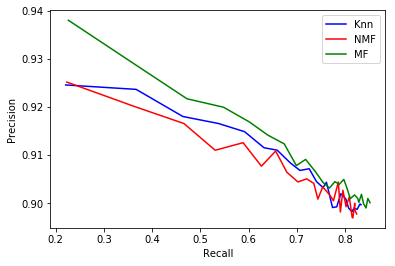

In [267]:
plt.figure()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_knn,precision_knn,color='blue',lw=1.5,label='Knn')
plt.plot(recall_NMF,precision_NMF,color='red',lw=1.5,label='NMF')
plt.plot(recall_MF,precision_MF,color='green',lw=1.5,label='MF')
plt.legend(loc="upper right")
plt.show()